In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from sklearn import svm
import datetime as dt
from sklearn.ensemble import RandomForestClassifier 

In [3]:
df = pd.read_csv("./match_data_yearly/all_years.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index(df["Date"])

In [4]:
df

,ID,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances,HomeElo,AwayElo,HomeED,AwayED
Date,,,,,,,,,,,,,,,,,
2006-03-04,6010903,2006,1,2006-03-04,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916,1500,1500,0,0
2006-03-05,6012807,2006,1,2006-03-05,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277,1500,1500,0,0
2006-03-05,6012231,2006,1,2006-03-05,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531,1500,1500,0,0
2006-03-05,6011323,2006,1,2006-03-05,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564,1500,1500,0,0
2006-03-05,6010820,2006,1,2006-03-05,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199,1500,1500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-19,20340120,2020,34,2020-12-19,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251,1594,1560,4,-6
2020-12-19,20340810,2020,34,2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825,1515,1524,9,-13
2020-12-19,20343331,2020,34,2020-12-19,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966,1453,1458,17,7


In [5]:
accuracies = []

def predict(year):
    df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
    X_train=df_past[["HomeElo","AwayElo","HomeED","AwayED"]].values
    y_train = df_past["W/L"].values
    
    df_future = df[f"{year}"]
    X_test = df_future[["HomeElo","AwayElo","HomeED","AwayED"]].values
    y_test = df_future["W/L"].values

    
    rf= RandomForestClassifier(max_depth=5)  
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
   
    accuracy = rf.score(X_test,y_test) 
    accuracies.append(accuracy)

In [6]:
for _ in range(10):
    for y in (2013,2014,2015,2016,2017,2018,2019,2020):
        predict(y)

In [7]:
# 8シーズン×10回の精度の平均
np.mean(accuracies)

0.46360294117647066

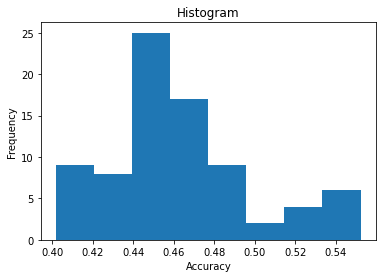

In [8]:
n, bins, patches=plt.hist(accuracies, bins=8)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

### 考察

以前まで外部サイトから取得していたeloratingとは違い今回は自分で算出したところ､精度が大きく下がった｡以前までの所得方法に誤りがあった可能性がある｡
また､今後の拡張性も考慮して自分で算出したratingを用いる｡

rating値しか使っていないので､ratingの大小で分類されやすく分類の精度が伸びていないのでは?と考えられる

### 較正値検証

較正値 = (予測勝率の和)/(実勝率の和)

較正値が1に近づけば近づくほど精度がいい

In [60]:
year = 2020

df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
X_train=df_past[["HomeElo","AwayElo","HomeED","AwayED"]].values
y_train = df_past["W/L"].values

df_future = df[f"{year}"]
X_test = df_future[["HomeElo","AwayElo","HomeED","AwayED"]].values
y_test = df_future["W/L"].values


rf= RandomForestClassifier(max_depth=5)  
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

accuracy = rf.score(X_test,y_test) 
print(accuracy)

0.46405228758169936


In [61]:
y_pred_proba=rf.predict_proba(X_test)
y_pred_proba # [引き分け, ホーム勝ち, アウェイ勝ち]

array([[0.26285781, 0.42294678, 0.31419541],
       [0.2592715 , 0.43258931, 0.30813919],
       [0.27646661, 0.45765603, 0.26587737],
       [0.25245623, 0.43256755, 0.31497622],
       [0.29581036, 0.52646577, 0.17772387],
       [0.20871712, 0.35810207, 0.43318081],
       [0.23692054, 0.31535391, 0.44772554],
       [0.22654617, 0.45590078, 0.31755306],
       [0.21862489, 0.5331917 , 0.24818341],
       [0.21782022, 0.38508293, 0.39709685],
       [0.28546811, 0.39837826, 0.31615363],
       [0.28739073, 0.39577507, 0.31683419],
       [0.26055306, 0.40647396, 0.33297298],
       [0.21151212, 0.38159298, 0.4068949 ],
       [0.2174305 , 0.452145  , 0.3304245 ],
       [0.266744  , 0.4002807 , 0.33297529],
       [0.26547411, 0.28674904, 0.44777685],
       [0.21917747, 0.37476284, 0.40605969],
       [0.25337871, 0.55135443, 0.19526686],
       [0.26077662, 0.47949814, 0.25972524],
       [0.19538052, 0.55139856, 0.25322092],
       [0.24892115, 0.40570271, 0.34537613],
       [0.

In [62]:
y_test

array([2, 0, 1, 1, 0, 2, 1, 2, 0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 2, 2,
       2, 2, 1, 0, 2, 1, 0, 2, 0, 0, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 0, 1, 1, 1, 2, 0,
       2, 2, 0, 2, 1, 1, 2, 0, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1,
       2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 2, 0, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 2,
       0, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 2,
       0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1,
       1, 2, 0, 2, 2, 1, 0, 0, 1, 0, 2, 1, 1, 0, 0, 2, 1, 2, 0, 2, 2, 1,
       1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 1, 2, 0, 1, 1, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 0, 2, 0, 0, 0, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 1, 0,
       0, 0, 0, 1, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2, 1,

In [79]:
df_future[["Home","Away","HomeElo","AwayElo","W/L"]]

,Home,Away,HomeElo,AwayElo,W/L
Date,,,,,
2020-02-21,shonan-bellmare,urawa-red-diamonds,1422,1484,2
2020-02-22,vegalta-sendai,nagoya-grampus-eight,1459,1431,0
2020-02-22,cerezo-osaka,oita-trinita,1558,1427,1
2020-02-22,kashiwa-reysol,consadole-sapporo,1503,1481,1
2020-02-22,kawasaki-frontale,sagan-tosu,1628,1456,0
...,...,...,...,...,...
2020-12-19,kashima-antlers,cerezo-osaka,1594,1560,0
2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,1515,1524,1
2020-12-19,sagan-tosu,oita-trinita,1453,1458,0


In [64]:
y_pred

array([1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1,
       2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1,
       2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2,
       1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2,
       2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,

In [65]:
count=0
pred_winrate_sum=0 # 予測勝率の和
actual_winrate_sum=0 # 実勝率の和

for index,row in df_future.iterrows():
    if row["HomeElo"] > row["AwayElo"]: # ホームが実力上位
        pred_winrate_sum += y_pred_proba[count][1] # ホームの予想勝率を加算
        if y_test[count] == 1: # 実際にホームが勝ったならば､1を加算
            actual_winrate_sum += 1
    elif row["AwayElo"] > row["HomeElo"]: # アウェイが実力上位
        pred_winrate_sum += y_pred_proba[count][2] # アウェイの予想勝率を加算
        if y_test[count] == 2: # 実際にアウェイが勝ったならば､1を加算
             actual_winrate_sum += 1 
    
    count+= 1

In [66]:
pred_winrate_sum

133.8721592713226

In [67]:
actual_winrate_sum

161

In [68]:
# 較正値(予測勝率と実勝率との比)
pred_winrate_sum/actual_winrate_sum 

0.8315040948529354

### 考察

較正値で評価すると､概ね1±0.2あたりに収まることから､eloratingで勝率を予測できることが分かる｡
改善の余地もまだまだある

In [80]:
match_id_list = df_future["ID"].values
match_result_list = df_future["W/L"].values

## toto予想

ホームクラブの勝率のみを考慮して､toto予想(0,1,2のどれを買うか)をしてみた｡

In [103]:
count = 0

print("結果 予想 正誤")

for (mid, ypred, result) in zip(match_id_list, y_pred_proba, match_result_list):
    if ypred[1] > 0.5 :
        if result == 1:
            print(f"{result} 1       ○")
            count += 1
        else:
            print(f"{result} 1       ✕")
    elif ypred[1] > 0.4:
        if result == 1 or result == 0:
            print(f"{result} 10    ○")
            count += 1
        else:
            print(f"{result} 10    ✕")
    elif ypred[1] > 0.3:
        print(f"{result} 102 ○") 
        count += 1
    elif ypred[1] > 0.2:
        if result == 0 or result == 2 :
            print(f"{result} 02    ○")
            count += 1
        else:
            print(f"{result} 02    ✕")
    else:
        if result == 2:
            print(f"{result} 2       ○") 
            count += 1
        else:
            print(f"{result} 2       ✕")
            
print(f"的中率 : {count / len(match_id_list)}")

結果 予想 正誤
2 10    ✕
0 10    ○
1 10    ○
1 10    ○
0 1       ✕
2 102 ○
1 102 ○
2 10    ✕
0 1       ✕
2 102 ○
2 102 ○
2 102 ○
1 10    ○
2 102 ○
1 10    ○
2 10    ✕
0 02    ○
2 102 ○
1 1       ○
2 10    ✕
2 1       ✕
2 10    ✕
2 1       ✕
2 10    ✕
1 10    ○
0 102 ○
2 102 ○
1 1       ○
0 10    ○
2 102 ○
0 10    ○
0 102 ○
0 10    ○
2 1       ✕
1 102 ○
2 10    ✕
1 102 ○
2 02    ○
1 10    ○
0 10    ○
1 1       ○
2 102 ○
1 10    ○
1 10    ○
1 10    ○
1 1       ○
1 02    ✕
1 102 ○
0 102 ○
0 102 ○
0 1       ✕
2 102 ○
2 10    ✕
2 02    ○
1 102 ○
2 10    ✕
1 102 ○
0 102 ○
1 10    ○
1 10    ○
0 02    ○
2 10    ✕
2 1       ✕
2 102 ○
2 102 ○
2 1       ✕
2 102 ○
2 02    ○
2 102 ○
0 1       ✕
2 1       ✕
1 1       ○
1 10    ○
1 10    ○
1 1       ○
0 10    ○
1 1       ○
2 1       ✕
1 10    ○
0 10    ○
2 102 ○
1 10    ○
0 10    ○
1 02    ✕
1 10    ○
1 102 ○
2 1       ✕
0 1       ✕
2 102 ○
2 10    ✕
0 102 ○
2 1       ✕
1 102 ○
1 102 ○
2 10    ✕
0 10    ○
2 102 ○
1 102 ○
2 10    ✕
1 10    ○
1 10    ○
0 102

### toto予想 考察

ホームクラブの予想勝率だけで､賭け方を決めて､実際に予想してみたら､意外と○が多い｡
もっとリターン額を考えトリプルやダブルを減らした賭け方ができれば､現実世界でも使えそう｡